Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 07: Compression

## Introduction

This week's sheet should be solved and handed in before the end of **Monday, January 13, 2025**. If you need help (and Google and other resources were not enough), feel free to use the StudIP forum. Please upload your results to your group's Stud.IP folder.

## Assignment 1: Redundancy and compression (5 points)

**a)** Explain in your own words the different types of redundancy mentioned on (CV-08 slide 55). How can you check for each of these types of redundancy?

Coding Redundancy - Huffman Coding
Coding redundancy occurs when the same amount of information can be represented with fewer bits. For example, grayscale images are typically stored using 8 bits per pixel, allowing 256 intensity levels. However, if an image only requires 4 intensity levels, it can be represented with just 2 bits per pixel, making the remaining 6 bits unnecessary.

Interpixel redundancy - RLE
Interpixel redundancy arises from the spatial correlation between neighboring pixels in an image, where adjacent pixels often share the same or similar values. Instead of encoding each pixel separately, this redundancy can be exploited to save space.

Psychovisual reduncdancy - Orthogonal transformations like fourier transform
Psychovisual redundancy is based on the human visual system's inability to perceive certain high-frequency details. This type of redundancy focuses on removing visually insignificant information while preserving perceptual quality.

**b)** Explain the differences between lossless and lossy compression. Name examples for both of them.

Lossless -
Compresses data without any loss of information, allowing exact reconstruction of the original data.
Ex - PNG

Lossy - 
Compresses data by discarding less significant information, resulting in irreversible data loss.
Ex - JPEG

**c)** Compare photos of a scenery to company or product logos that can often be found on websites. Describe their features and explain which type of compression should be used for either.

Photos of a scenery are detailed and include a lot of information. Lossy compression can be used here.
Photos of a product logo are simple and include precise edges. Lossless compression can be used here.

## Assignment 2: Entropy based compression (8 points)

**a)** Explain the idea of Huffman coding. What is the maximal compression factor that can be achieved for a given image? Load an image and compute that value (you may use `dolly.png` as an example. Make sure to load as 8-bit gray scale image).

A lossless compression algorithm that assigns variable-length codes to symbols based on their frequency of occurrence. Frequently occurring symbols get shorter codes, reducing overall file size without losing information.

Max Compression Factor= Number of bits original/Entropy


In [96]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')
hist, bin_edges = np.histogram(img, bins=256, range=(0, 256), density=True)
normalized_histogram = {bin_edges[i]: hist[i] for i in range(len(hist))}
hist = hist[hist > 0]
entropy = -np.sum(hist * np.log2(hist))
compression_factor=8/entropy
print(entropy)
print(compression_factor)


7.426579595591898
1.0772119112206728


**b)** Now compute the relative frequencies (normalized histogram) of the image and generate an (approximately) balanced tree, as described in (CV-08 slide 33). *Hint:* you may use Python tuples as building blocks of a tree. Every non-leaf node is a pair `(left, right)` where `left` and `right` are the left and right subtrees, respectively (of course you are free to choose another approach if you prefer to do so).

In [85]:
import heapq
    
sorted_items = sorted(normalized_histogram, key=lambda x: x)

class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq
    
def build_huffman_tree(histogram):
    heap = [HuffmanNode(char, freq) for char, freq in normalized_histogram.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)

        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        
        heapq.heappush(heap, merged)
    
    return heap[0]



tree = build_huffman_tree(sorted_items)


In [86]:
def print_huffman_tree(node, indent=""):
    if node is not None:
        if node.char is not None:
            print(f"{indent}Leaf: {node.char} - Frequency: {node.freq:.4f}")
        else:
            print(f"{indent}Node - Frequency: {node.freq:.4f}")
            print_huffman_tree(node.left, indent + "    ")
            print_huffman_tree(node.right, indent + "    ")
print_huffman_tree(tree)

Node - Frequency: 1.0000
    Node - Frequency: 0.4144
        Node - Frequency: 0.1938
            Node - Frequency: 0.0945
                Node - Frequency: 0.0468
                    Node - Frequency: 0.0232
                        Node - Frequency: 0.0116
                            Leaf: 45.0 - Frequency: 0.0058
                            Node - Frequency: 0.0058
                                Node - Frequency: 0.0029
                                    Leaf: 229.0 - Frequency: 0.0014
                                    Node - Frequency: 0.0014
                                        Leaf: 193.0 - Frequency: 0.0007
                                        Leaf: 235.0 - Frequency: 0.0007
                                Node - Frequency: 0.0029
                                    Leaf: 223.0 - Frequency: 0.0015
                                    Leaf: 150.0 - Frequency: 0.0015
                        Leaf: 75.0 - Frequency: 0.0116
                    Node - Frequency: 0.0236
      

**c)** Now create a prefix free code from this tree, by traversing it following the idea sketched in (CV-08 slide 34). *Hint:* if you used the tuple representation recommended in (b), you can use `isinstance(node, tuple)` to check if `node` is an inner node or a leaf.

In [90]:
# initialize a list of code values
codes = normalized_histogram.copy()
# function to recursively traverse the tree.
# For every inner node assign prefix "0" to the left subtree
# and prefix "1" to the right subtree.
def assign_codes(codes, tree, prefix=''):
    if tree.char is None:  
        codes.update(assign_codes(codes,tree.left, prefix + "0"))  # Traverse left with '0'
        codes.update(assign_codes(codes,tree.right, prefix + "1"))  # Traverse right with '1'
        return codes
    else:  # Leaf node
        return {tree.char: prefix}  # Assign the current prefix to the leaf symbol

assign_codes(codes,tree)
for bit,code in codes.items():
    print( bit,code, normalized_histogram[bit])

0.0 10100011010100001 8.333333333333334e-06
1.0 111110111001011 4.5833333333333334e-05
2.0 1011110100111 0.00014166666666666668
3.0 1111000101 0.0013791666666666666
4.0 1011101 0.008804166666666667
5.0 101010 0.015889583333333332
6.0 011010 0.013983333333333334
7.0 1101111 0.01040625
8.0 1010111 0.008095833333333333
9.0 1010000 0.007752083333333333
10.0 1001111 0.0077395833333333336
11.0 1001100 0.00743125
12.0 0101111 0.00691875
13.0 0100110 0.006689583333333333
14.0 0011010 0.006216666666666666
15.0 0010001 0.0060625
16.0 0011011 0.0062541666666666666
17.0 0011001 0.00620625
18.0 0101100 0.006866666666666667
19.0 0100111 0.006722916666666667
20.0 0101110 0.006910416666666666
21.0 0111010 0.00715625
22.0 0111000 0.0070375
23.0 0111100 0.00718125
24.0 0110010 0.006970833333333333
25.0 0101101 0.0068895833333333335
26.0 0110110 0.007
27.0 0111111 0.007241666666666667
28.0 1000001 0.007295833333333333
29.0 0111110 0.0072208333333333334
30.0 1001000 0.00739375
31.0 1000101 0.0073354166666

**d)** Compute the compression ratio that you can achieve with that code. Compare this with the maximal value computed in part (a). Explain your observation.

In [97]:
acc = 0

def calculate_average_code_length(normalized_histogram, huffman_codes):
    total_length = 0
    for symbol, prob in normalized_histogram.items():
        code_length = len(huffman_codes[symbol])
        total_length += prob * code_length
    return total_length

acc = calculate_average_code_length(normalized_histogram,codes)

print("{:.2f} bits per pixel".format(acc))
print(f"Efficiency: {(entropy / acc) * 100:.2f}%")

7.46 bits per pixel
Efficiency: 99.56%


YOUR ANSWER HERE

## Assignment 3: Run length encoding (7 points)


**a)** Explain the idea of *run length encoding*. What are advantages and disadvantages? In what situations should it be applied?

YOUR ANSWER HERE

**b)** Analyze the run lengths in a gray scale image (8 bit = 256 gray values) by counting the number of runs and the average run length and displaying a histogram of the run lengths. What do you observe? Can you benefit from run length encoding here? (you may use `dolly.png` as an example again, but you may also experiment with other images. Make sure to load it as 8-bit gray scale image).

480000


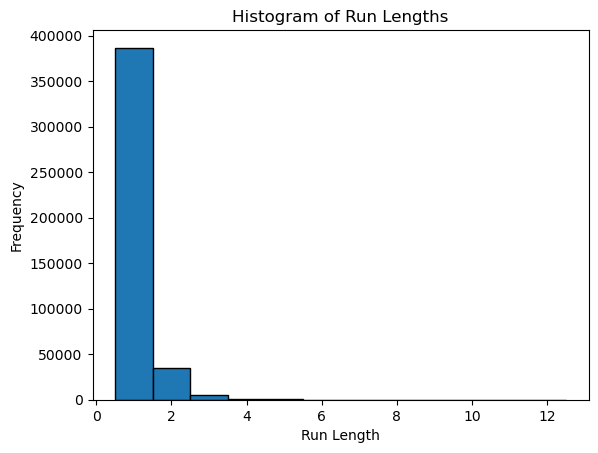

Average Run Length: 1.12


In [115]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')

def run_length_encoding(bit_plane):
    rle = []
    for i in range(bit_plane.shape[0]):
        row = []
        prev = bit_plane[i][0]
        count = 1
        for j in range(1, bit_plane.shape[1]):
            if bit_plane[i][j] == prev:
                count += 1
            else:
                row.append((count, prev))
                count = 1
            prev = bit_plane[i][j]
        row.append((count, prev))  # Append the last run
        rle.append(row)
    return rle

rle = run_length_encoding(img)
# Extract run lengths
run_lengths = [length for row in rle for length, _ in row]

# Calculate average run length
average_run_length = np.mean(run_lengths)

print(np.sum(run_lengths))

# Plot histogram of run lengths
plt.hist(run_lengths, bins=range(1, max(run_lengths) + 2), edgecolor='black', align='left')
plt.title("Histogram of Run Lengths")
plt.xlabel("Run Length")
plt.ylabel("Frequency")
plt.show()

# Print average run length
print(f"Average Run Length: {average_run_length:.2f}")
        
        

**c)** Now consider the individual bit planes. First display the bit planes as in (CV-08 slide 38). What do you observe? Apply your analysis from part (b) to each bitplane.

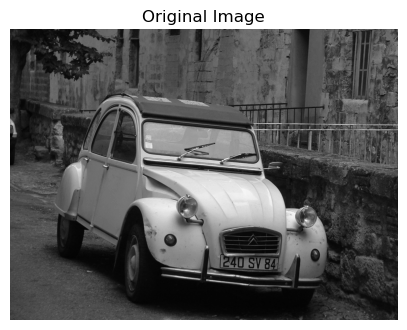

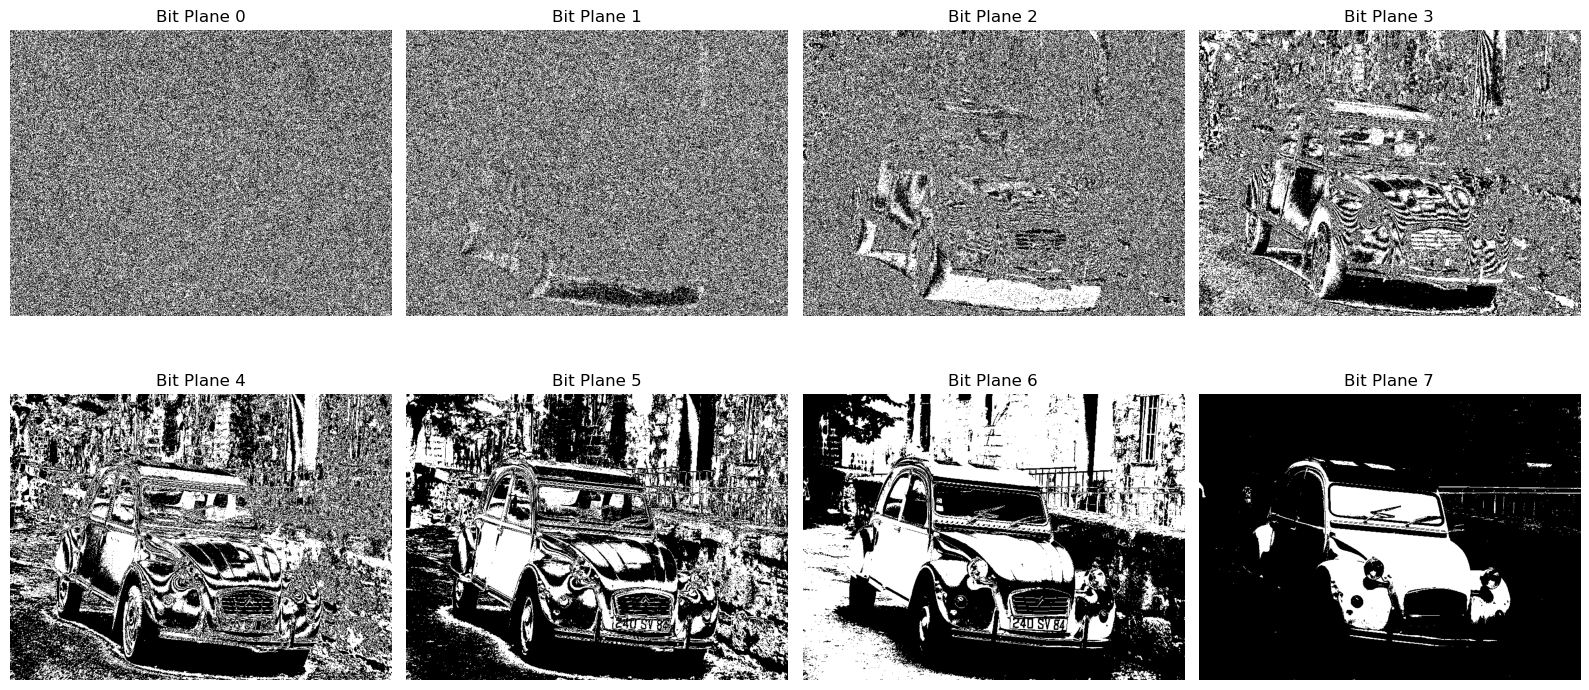

Average Run Length for Bit Plane 0: 2.00
Average Run Length for Bit Plane 1: 2.03
Average Run Length for Bit Plane 2: 2.20
Average Run Length for Bit Plane 3: 2.65
Average Run Length for Bit Plane 4: 3.73
Average Run Length for Bit Plane 5: 6.03
Average Run Length for Bit Plane 6: 12.94
Average Run Length for Bit Plane 7: 70.27


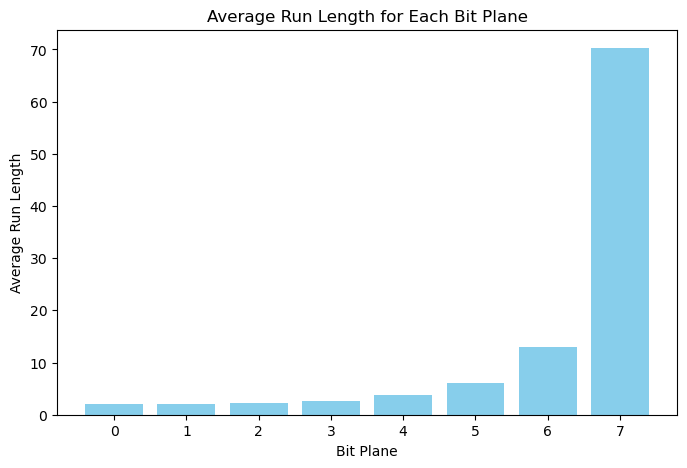

In [116]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

# Load the image in grayscale
img = imageio.imread('images/dolly.png', pilmode='L')

# Display the original image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.show()

# Extract and display the bit planes
bit_planes = [(img >> i) & 1 for i in range(8)]  # Extract bit planes

# Plot all 8 bit planes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(bit_planes[i], cmap='gray')
    ax.set_title(f"Bit Plane {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Apply RLE to each bit plane
rle_results = [run_length_encoding(bit_plane) for bit_plane in bit_planes]

# Calculate average run length for each bit plane
avg_run_lengths = []
for i, rle in enumerate(rle_results):
    run_lengths = [length for row in rle for length, _ in row]
    avg_run_length = np.mean(run_lengths)
    avg_run_lengths.append(avg_run_length)
    print(f"Average Run Length for Bit Plane {i}: {avg_run_length:.2f}")

# Plot histogram of average run lengths
plt.figure(figsize=(8, 5))
plt.bar(range(8), avg_run_lengths, color='skyblue')
plt.xlabel("Bit Plane")
plt.ylabel("Average Run Length")
plt.title("Average Run Length for Each Bit Plane")
plt.xticks(range(8))
plt.show()


**d)** Explain the idea of the *Gray code*. Why is it better suited for run length encoding? Compute a Gray code for a 256 bit image and recode the image `dolly.png`. Then analyze the run lengths of the individual bit planes of the recoded image.

Gray code, also known as Reflected Binary Code, is a binary numeral system where two successive values differ in only one bit. This contrasts with regular binary numbers, where multiple bits can change between consecutive values. The main advantage of Gray code is that it minimizes the errors that occur when changing between adjacent values, which is especially important in hardware systems and signal encoding.

In [ ]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')

# YOUR CODE HERE
raise NotImplementedError()